In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from cmu_model.diffusion_model import Model
from cmu_model.utilities import dict2namespace
from cmu_model.reconstruct import load_recons_data

import yaml
from IPython import display
import time


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [3]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)

Test data shape:  (4, 320, 256, 256)


In [4]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [5]:
'''
Reading the pretrained parameters
'''
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
#state_dict = torch.load('trained_model_unconditional.pth', map_location=torch.device('cpu'), weights_only=True)



path = "/home/baris/Documents/DDSim/baris-personal/cmu_model/kmflow_re1000_rs256_sparse_recons.yml"
with open(path, 'r') as f:
    config = yaml.safe_load(f)
    config = dict2namespace(config)
    
model = Model(config)
state_dict = torch.load('/home/baris/Documents/DDSim/baris-personal/cmu_model/baseline_ckpt.pth', map_location=torch.device('cpu'), weights_only=True)
print(state_dict[4])
model.load_state_dict(state_dict[4])
model.to(device)
model.eval();

{'temb.dense.0.weight': tensor([[-0.0314,  0.0013, -0.0347,  ...,  0.0361,  0.0045, -0.1280],
        [-0.1122, -0.1018,  0.0083,  ...,  0.0126, -0.1163, -0.1215],
        [ 0.0198, -0.0125,  0.0834,  ..., -0.0353,  0.0607, -0.0628],
        ...,
        [-0.0091,  0.0056,  0.0333,  ...,  0.0487,  0.0482, -0.1235],
        [-0.0571, -0.1108, -0.0532,  ..., -0.1285, -0.0548, -0.0028],
        [ 0.0015,  0.0050,  0.0113,  ...,  0.0661, -0.0323, -0.0911]]), 'temb.dense.0.bias': tensor([-0.0790, -0.1287, -0.0139, -0.0230, -0.0665, -0.0638,  0.0393, -0.1204,
        -0.0348,  0.0087, -0.0186,  0.0654, -0.0660,  0.0334, -0.0952,  0.0454,
         0.0187,  0.0336,  0.0209,  0.0013,  0.1264, -0.0169,  0.0104,  0.0239,
        -0.0332,  0.0266, -0.0782,  0.1015, -0.1237, -0.1286,  0.1418, -0.0039,
        -0.0593,  0.0902, -0.1250, -0.0038, -0.0402, -0.0205, -0.0145,  0.0466,
        -0.0719, -0.0297,  0.0623, -0.0566, -0.0782,  0.0331,  0.0138,  0.0561,
        -0.0283, -0.1271, -0.0363,  0.03

In [51]:
def denoise(guidance, model, K, beta_min = 1e-4, beta_max = 0.02, steps=[1000], output_freq=10, show_intermediate_output=False):
    for i in range(K):
        betas = torch.linspace(beta_min, beta_max, steps[i]).to(device)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        epsilon = torch.randn_like(guidance).to(device)
        x_t = torch.sqrt(alphas_cumprod[steps[i]-1]) * guidance + \
        torch.sqrt(1 - alphas_cumprod[steps[i]-1]) * epsilon
        for t in reversed(range(1, steps[i]+1)):
            #assert x_t.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot                
            # Calculate the parameters
            alpha_t_bar = alphas_cumprod[t-1]
            beta_t = betas[t-1]
            alpha_t = alphas[t-1]
            # Predict the noise using the model
            with torch.no_grad():
                epsilon_theta = model(x_t, (torch.tensor(t, dtype=torch.int16)).unsqueeze(-1).to(device))

            # Make sure the output of the model (the predicted noise) has a single channel
            #assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."
            # Calculate the mean of the previous step in the backward process of diffusion model
            mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
            # Add noise for all but the last step (strictly follow the algorithm)
            if t > 1:
                # z = torch.randn_like(x_t).to(device)
                z = torch.randn_like(x_t).to(device)
                x_t = mean + torch.sqrt(beta_t) * z
            else:
                x_t = mean

        guidance = x_t
        #plt.show()
    return x_t

(4, 320, 1024)


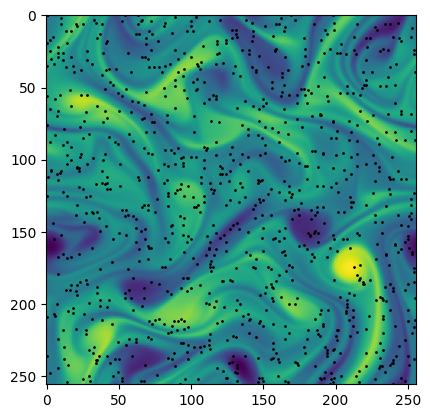

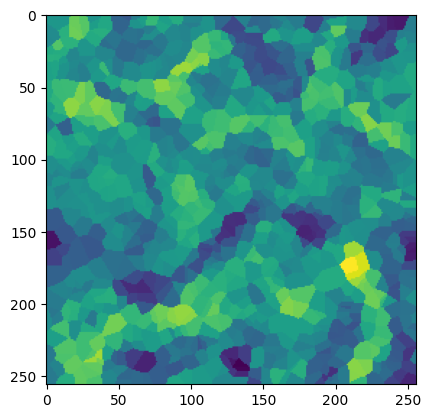

In [52]:
#Randomly choose a fixed percentage of points from the test snapshot
percentage = 1.5625
factor = percentage/100
N = int(256**2 * factor)
test_snapshots = test_data[-4:]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
sparse_measurement =  test_snapshots[..., nx, ny]

#Nearest neighbor interpolation
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
coordinates = np.vstack((nx, ny)).T

print(sparse_measurement.shape)

sparse_measurement_list = []
for i in range(sparse_measurement.shape[0]):
    sl_list = []
    for j in range(sparse_measurement.shape[1]):
        sl_list.append(interpolate.griddata(coordinates, sparse_measurement[i,j], (xx,yy), method='nearest').T)
    sparse_measurement_list.append(sl_list)

interpolated_sparse_measurement = np.array(sparse_measurement_list)
#interpolated_sparse_measurement = interpolate.griddata(coordinates, sparse_measurement, (xx,yy), method='nearest').T

#Visualize location of selected points and interpolated sparse measurements
figure,ax = plt.subplots()
figure2,ax2 = plt.subplots()
ax.imshow(test_snapshots[3,90])
mask = np.zeros((256, 256))
mask[nx, ny] = 1
ax.scatter(xx*mask, yy*mask, s=1, c="black")
ax2.imshow(interpolated_sparse_measurement[3,90])


(4, 320, 256, 256)
data shape: torch.Size([1272, 3, 256, 256])
torch.Size([1272, 3, 256, 256])


/tmp/ipykernel_96926/2313221267.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sparse_measurement = torch.tensor(sparse_measurement[-10:], dtype=torch.float32).to(device)


data shape: torch.Size([1272, 3, 256, 256])


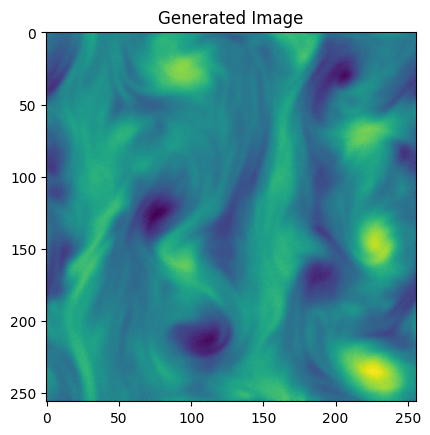

In [ ]:
#Generate high fidelity data from sparse mesurements
sparse_measurement = load_recons_data(interpolated_sparse_measurement)
#
sparse_measurement = torch.tensor(sparse_measurement[-10:], dtype=torch.float32).to(device)
test_snapshots = load_recons_data(test_snapshots)
K = 1
steps = np.ones((K,), dtype=np.int16) * 300
generated_image = denoise(sparse_measurement, model,steps=steps, K=K, beta_max=0.002, output_freq=40, show_intermediate_output="False").squeeze().detach().cpu().numpy()
sparse_measurement = sparse_measurement.detach().cpu().numpy()


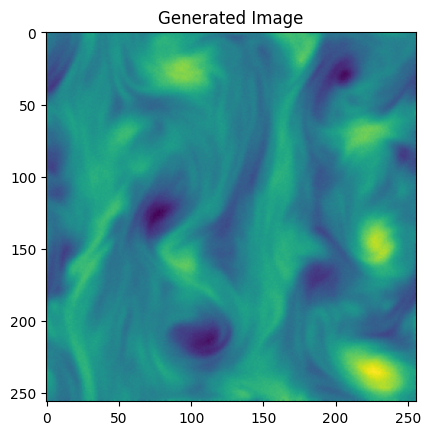

In [ ]:
plt.imshow(sparse_measurement[2,0])
plt.title("Generated Image")
plt.savefig("beta_max_0_02_S_400.png", dpi=400)

Input SSIM:  0.49261198968691994
Generated Image SSIM:  0.5011572266839226
Generated Image PSNR:  26.418664897593793
Average Relative Error at Sparse Measurement Locations: 122.09818267822266%
381
0.036839467 0.0145641565


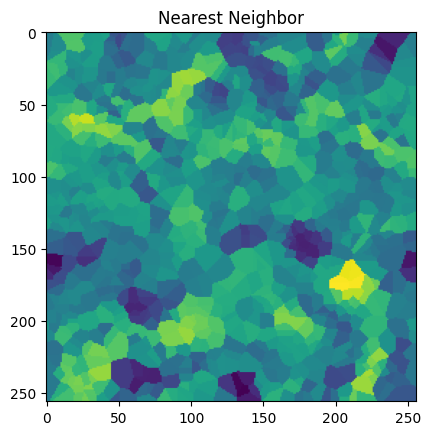

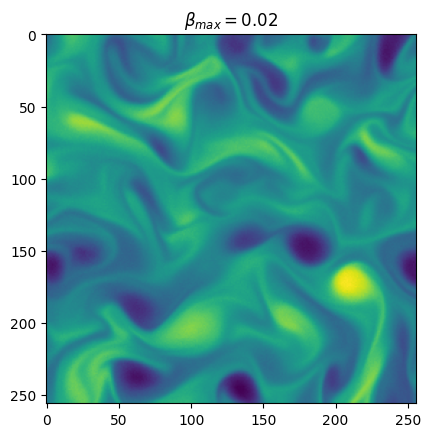

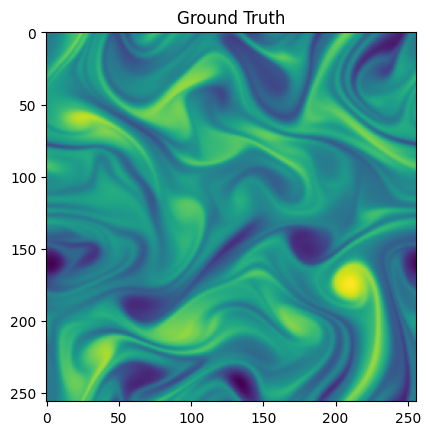

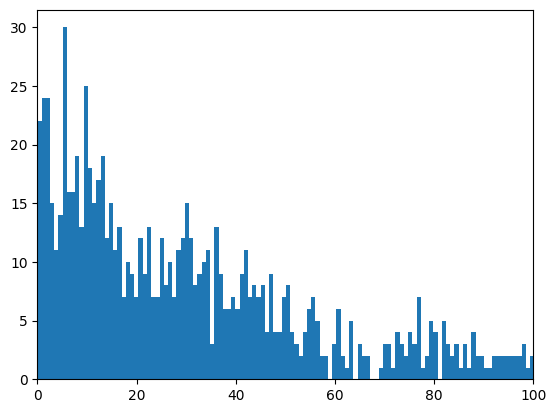

In [ ]:
#Plot generated field and ground truth
figure3, ax3  = plt.subplots()
figure4, ax4 = plt.subplots()
figure5, ax5 = plt.subplots()
figure6, ax6 = plt.subplots()

ax3.imshow(sparse_measurement.squeeze().detach().cpu().numpy())
ax3.set_title("Nearest Neighbor")
figure3.savefig("Nearest Neighbor.png", dpi=400)

ax4.imshow(generated_image)
ax4.set_title(r"$\beta_{max}=0.02$")
figure4.savefig("Beta_max_0.02.png", dpi=400)

ax5.imshow(test_snapshots)
ax5.set_title("Ground Truth")
figure5.savefig("Ground_Truth.png", dpi=400)

#Calculate quality metrics
PSNR = peak_signal_noise_ratio(test_snapshots, generated_image, data_range=2.0)
SSIM = structural_similarity(test_snapshots, generated_image, data_range=2.0)
SSIM_Sparse = structural_similarity(test_snapshots, interpolated_sparse_measurement, data_range=2.0)
print("Input SSIM: ", SSIM_Sparse)
print("Generated Image SSIM: ", SSIM)
print("Generated Image PSNR: ", PSNR)


#Compare values at sparse measurement locations
generated_image_sparse_measurements = generated_image[nx, ny]
ground_truth_sparse_measurements = test_snapshots[nx, ny]
sparse_measurement_error = 100*np.abs((generated_image_sparse_measurements - ground_truth_sparse_measurements)/ground_truth_sparse_measurements)
print(f"Average Relative Error at Sparse Measurement Locations: {np.mean(sparse_measurement_error)}%")
ax6.hist(sparse_measurement_error, bins=10000)
ax6.set_xlim([0,100])
print(np.sum(sparse_measurement_error < 20))
print(generated_image_sparse_measurements[24], ground_truth_sparse_measurements[24])




S = 100
K = 1
Input SSIM: 0.49261198968691994
Generated Image SSIM: 0.26897586302213977
Generated Image PSNR: 22.516388410558466
S = 200
K = 1
Input SSIM: 0.49261198968691994
Generated Image SSIM: 0.13003703354800586
Generated Image PSNR: 20.370973555981053
S = 300
K = 1
Input SSIM: 0.49261198968691994
Generated Image SSIM: 0.039352691279149685
Generated Image PSNR: 18.493636605447634
S = 400
K = 1
Input SSIM: 0.49261198968691994
Generated Image SSIM: 0.014509723965729969
Generated Image PSNR: 17.876644918632124


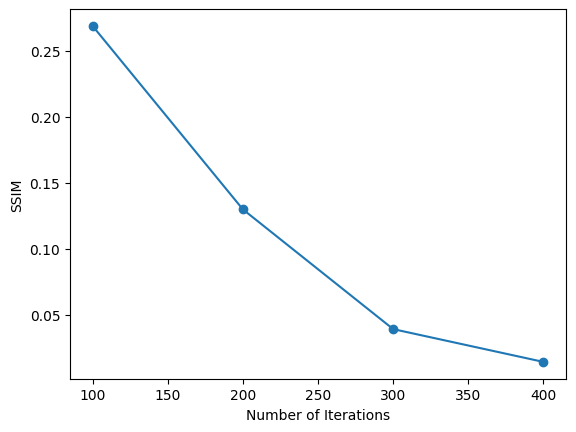

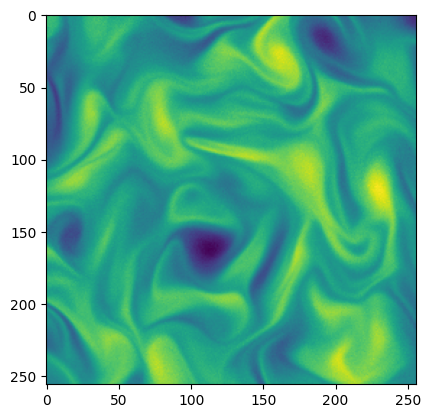

In [ ]:
import os
sparse_measurement = torch.tensor(interpolated_sparse_measurement, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
S = [100,200,300,400]
K = [1]
path = "/home/baris/Documents/DDSim/baris-personal/sparse/"




def parametric(K,S):
    figure, axis = plt.subplots()
    figure2, axis2 = plt.subplots()
    SSIM_Sparse_List = []
    SSIM_List = []
    MSE_List = []

    for s in S:
        for k in K:           
            path_K = os.path.join(path, "K_" + str(k))
            path_K_str = path + "K_" + str(k)
            if not os.path.exists(path_K):
                os.makedirs(path_K)
            plt.imshow(test_snapshots)
            plt.savefig(path_K_str + "/ground_truth")

            steps = np.ones((k,), dtype=np.int16) * s
            generated_image = denoise(sparse_measurement, model,steps=steps, K=k, beta_max=0.02, output_freq=10).squeeze().detach().cpu().numpy()
            PSNR = peak_signal_noise_ratio(test_snapshots, generated_image, data_range=2.0)
            SSIM = structural_similarity(test_snapshots, generated_image, data_range=2.0)
            SSIM_Sparse = structural_similarity(test_snapshots, interpolated_sparse_measurement, data_range=2.0)
            MSE = np.mean((test_snapshots - generated_image)**2)

            print(f"S = {s}")
            print(f"K = {k}")
            print(f"Input SSIM: {SSIM_Sparse}")
            print(f"Generated Image SSIM: {SSIM}")
            print(f"Generated Image PSNR: {PSNR}")
            plt.imshow(generated_image)
            plt.savefig(path_K_str + "/S_" + str(s))
            SSIM_List.append(SSIM)
            SSIM_Sparse_List.append(SSIM_Sparse_List)
            MSE_List.append(MSE)

    if len(K) == len(SSIM_List):
        axis.plot(K, SSIM_List, "-o")
        independent_variable = "Number of Timesteps"
    elif len(S) == len(SSIM_List):
        axis.plot(S, SSIM_List, "-o")
        independent_variable = "Number of Iterations"


    axis.set_xlabel(independent_variable)
    axis.set_ylabel("SSIM")
    figure.savefig(independent_variable + "_vs_SSIM_2.png", dpi=400)

parametric(K,S)


-1.0 1.0


(array([0.03446038, 0.03938348, 0.03938329, 0.04307547, 0.03446038,
        0.04676788, 0.0443062 , 0.06522857, 0.07261329, 0.07015149,
        0.1329186 , 0.21660914, 0.2744523 , 0.2387612 , 0.25352993,
        0.29045246, 0.25722273, 0.24983775, 0.27322157, 0.30152904,
        0.30275977, 0.35937252, 0.46767769, 0.58459712, 0.51567495,
        0.59690442, 0.67197739, 0.79874427, 0.79012726, 0.86028081,
        0.92304586, 0.92674027, 0.94273977, 0.97104424, 1.10273477,
        1.11011649, 1.26272977, 1.39687607, 1.54825931, 1.63317581,
        1.90517581, 2.14515858, 2.23746316, 2.17838823, 2.17716797,
        2.19315696, 2.33345993, 2.14147669, 2.18084968, 2.21038715,
        2.25469335, 2.17347577, 2.06762272, 2.02577798, 2.03808526,
        1.99255791, 1.95316504, 1.72055748, 1.69102814, 1.63440653,
        1.52856394, 1.39318388, 1.18519658, 1.12119304, 1.02273481,
        1.01658606, 0.94027605, 0.93904532, 0.91812295, 0.81966866,
        0.80735744, 0.73843669, 0.77290078, 0.69

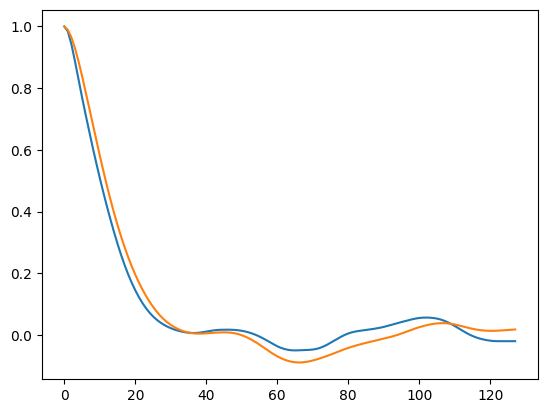

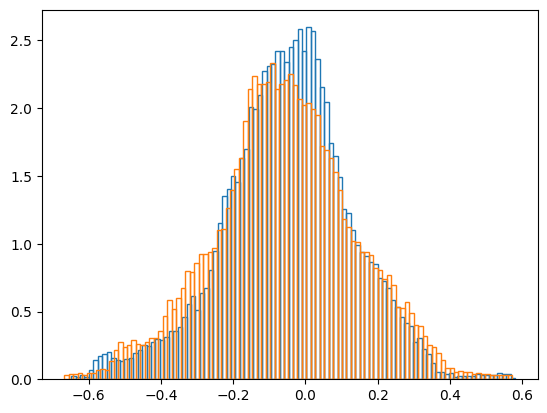

In [ ]:
def two_point_corr(field):
    number_of_cells = field.shape[0]
    mean = np.mean(field)
    field_prime = field - mean
    var = np.mean(field_prime * field_prime)
    f_corr = []
    for ii in range(number_of_cells // 2):
        f_corr_ii = np.mean(field_prime * np.roll(field_prime, shift=ii, axis=0)) / var # longitudinal
        f_corr.append(f_corr_ii)
    f_corr = np.array(f_corr)
    return f_corr
print(np.min(test_data), np.max(test_data))
f_corr_gt = two_point_corr(test_snapshots)
f_corr = two_point_corr(generated_image)
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
ax.plot(f_corr_gt)
ax.plot(f_corr)

ax2.hist(generated_image.flatten(), bins=100, density=True, facecolor="none", edgecolor="C0")
ax2.hist(test_snapshots.flatten(), bins=100, density=True, facecolor="none",  edgecolor="C1")
